Number of DAGs meeting criteria: 36069

Summary Statistics of Filtered DAGs:
Nodes - Mean: 3.30, Min: 1, Max: 9
Edges - Mean: 1.22, Min: 0, Max: 11
Depth - Mean: 1.94, Min: 1, Max: 7
Width - Mean: 2.26, Min: 1, Max: 8
Apps - Mean: 1.85, Min: 0, Max: 5


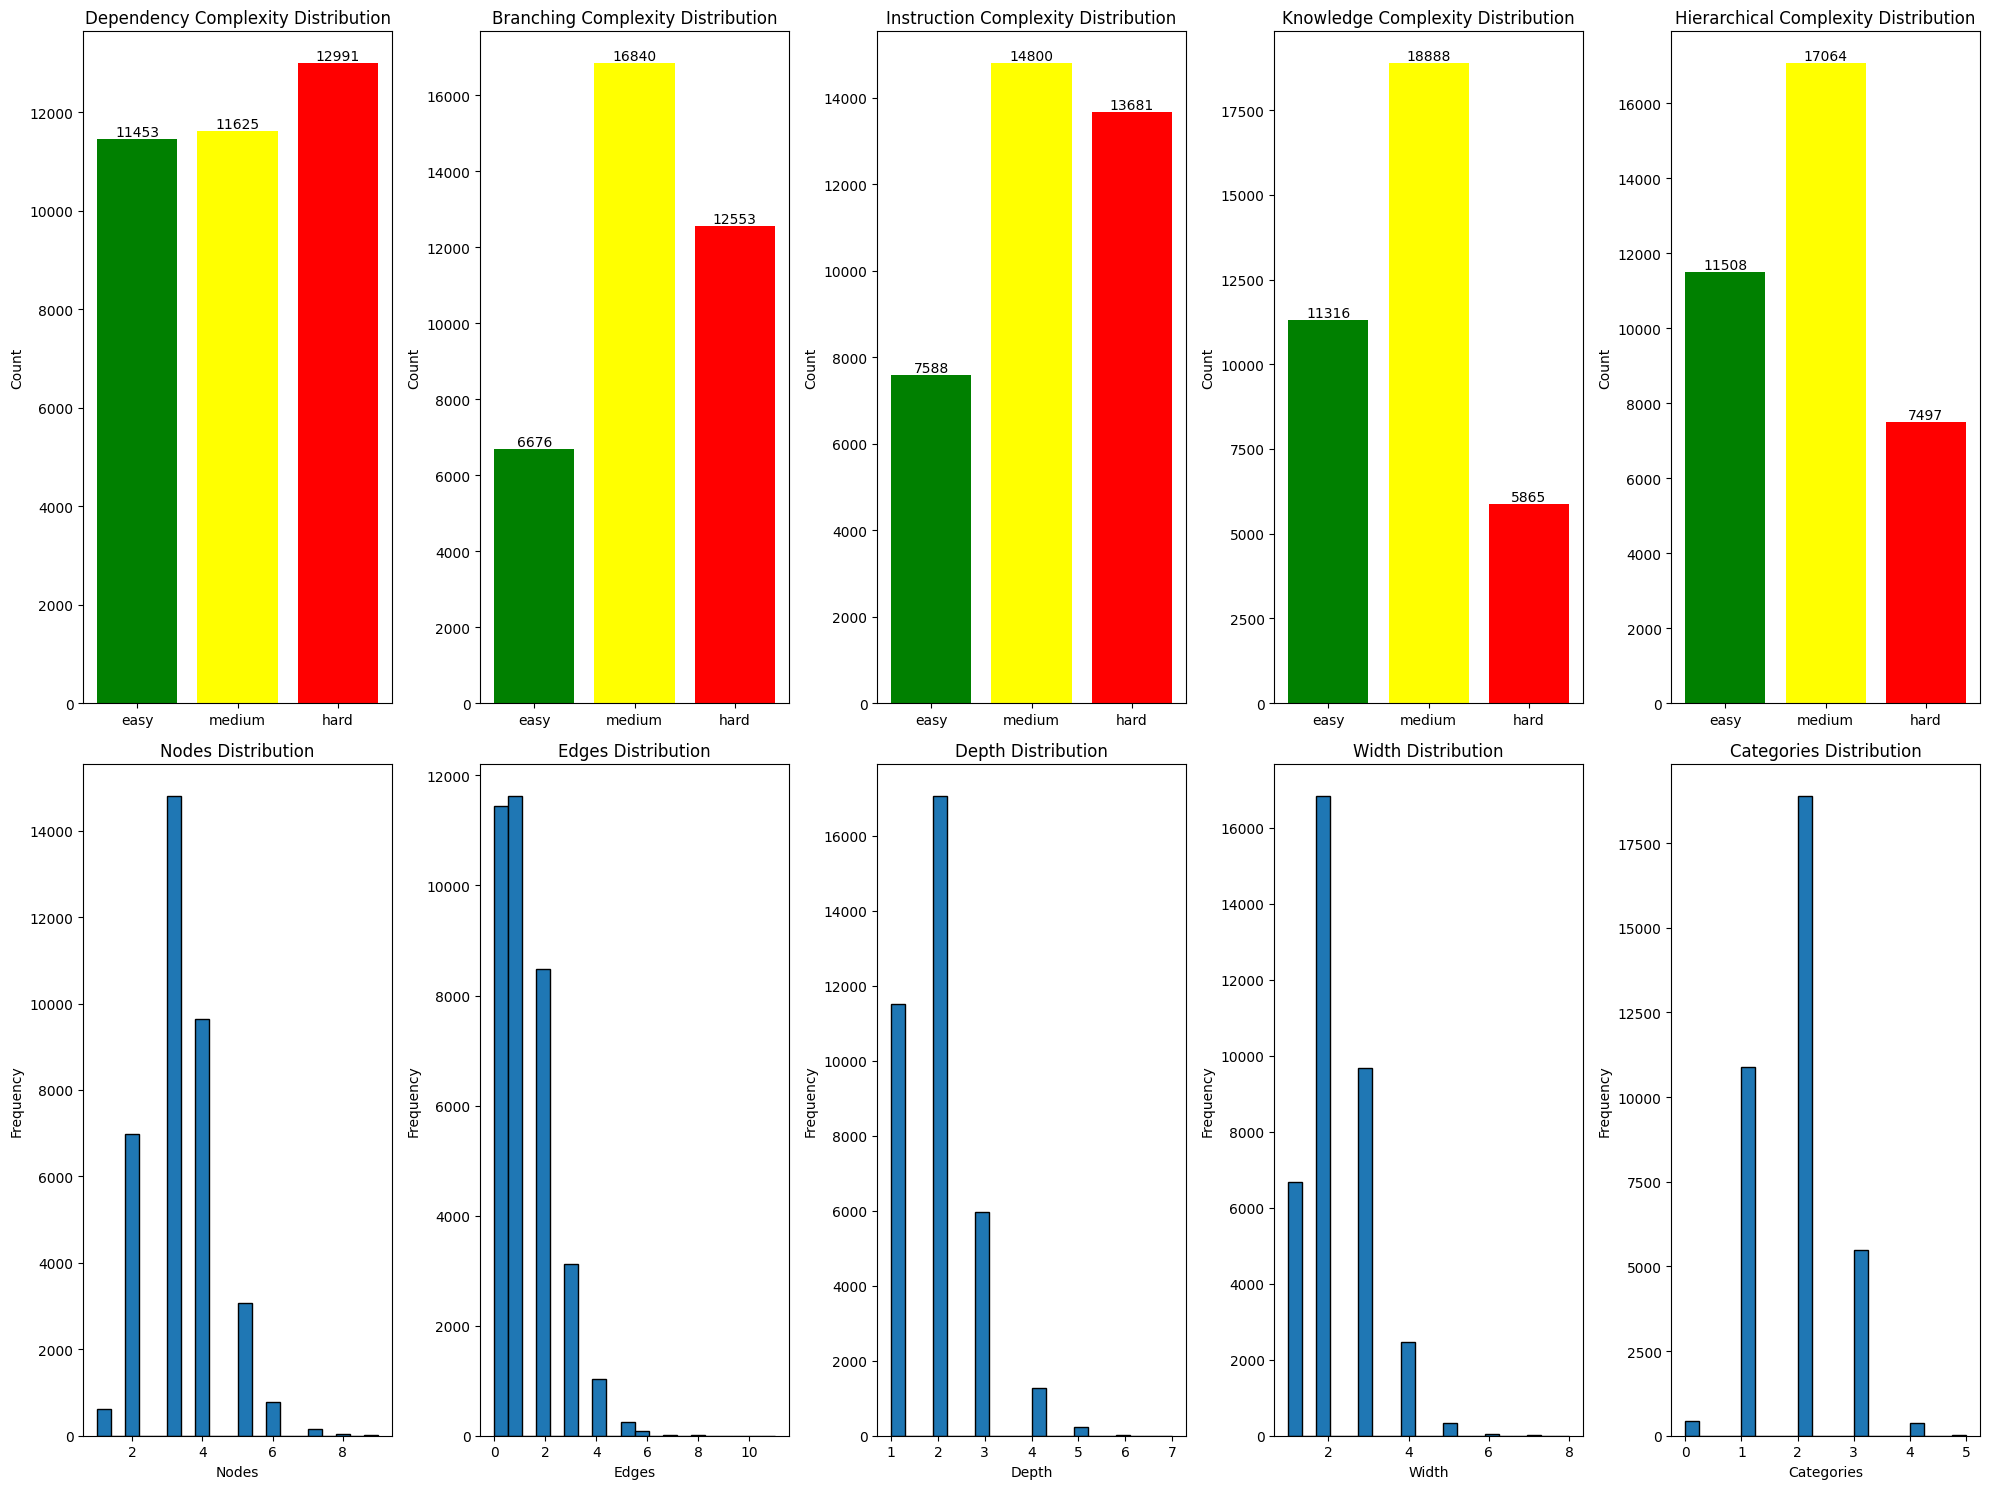

In [15]:
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from queue import Queue

app_categories = {
    "Social Communication": [
        "Zoom Workplace", "Skype", "People", "Mail"
    ],
    "Multimedia Playback": [
        "Media Player", "Spotify", "Photos", "TuneIn"
    ],
    "Multimedia Editing": [
        "Adobe Photoshop Express", "Microsoft Clipchamp", "paint.net", "Openshot", "Handbrake", "Paint"
    ],
    "Office": [
        "Word", "PowerPoint", "Excel"
    ],
    "Utility Tools": [
        "Calculator", "7-Zip", "PDF24", "Power Automate", "Wikipedia", "BreeZip", "Maps", "Calendar", "Zotero", "DeepL"
    ],
    "Programming": [
        "Visual Studio Code", "Cursor", "Windows PowerShell ISE"
    ],
    "System Management": [
        "File Explorer", "Settings", "Control Panel", "Microsoft Store"
    ],
    "Web Browsing": [
        "Google Chrome", "Microsoft Edge"
    ],
    "Screen Capture": [
        "Record Screen", "Snipping Tool", "OBS Studio", "ShareX"
    ],
    "Task Management": [
        "Microsoft To Do", "Todoist", "Notion"
    ],
    "Note Management": [
        "Evernote", "OneNote", "Sticky Notes", "Sticky Notes (New)"
    ],
    "Lifestyle": [
        "Recipe Keeper", "paisa"
    ]
}

def get_complexity_level(value, dimension):
    if dimension == 'Dependency':
        if value <= 0:
            return "easy"
        elif value <= 1:
            return "medium"
        else:
            return "hard"
    elif dimension == 'Branching':
        if value <= 1:
            return "easy"
        elif value <= 2:
            return "medium"
        else:
            return "hard"
    elif dimension == 'Instruction':
        if value <= 2:
            return "easy"
        elif value <= 3:
            return "medium"
        else:
            return "hard"
    elif dimension == 'Knowledge':
        if value <= 1:
            return "easy"
        elif value <= 2:
            return "medium"
        else:
            return "hard"
    elif dimension == 'Hierarchical':
        if value <= 1:
            return "easy"
        elif value <= 2:
            return "medium"
        else:
            return "hard"


def filter_dags(min_nodes=None, max_nodes=None,
               min_edges=None, max_edges=None, 
               min_depth=None, max_depth=None,
               min_width=None, max_width=None,
               min_apps=None, max_apps=None,
               data_dir="D:\data\[explicit_app]task_DAG_batch1"):
    
    json_files = [f for f in os.listdir(data_dir) 
                  if f.endswith('.json') and f.replace('.json','').isdigit()]
    
    with open('D:/data/all_task.json', 'r') as f:
        subtasks = json.load(f)
        subtask_map = {subtask['id']: subtask for subtask in subtasks}
    
    filtered_dags = []
    stats = {
        'node_counts': [],
        'edge_counts': [], 
        'depths': [],
        'widths': [],
        'category_counts': [],
        'complexities': []
    }

    def get_dag_depth_width(nodes, edges):
        level_widths = defaultdict(int)
        visited = set()
        
        incoming = defaultdict(int)
        for src, dsts in edges.items():
            for dst in dsts:
                incoming[dst] += 1
        roots = [node for node in nodes if incoming[node] == 0]
        
        if not roots:
            return 0, 0
            
        q = Queue()
        for root in roots:
            q.put((root, 0))
            visited.add(root)
            level_widths[0] += 1
            
        while not q.empty():
            node, level = q.get()
            
            if node in edges:
                for next_node in edges[node]:
                    if next_node not in visited:
                        visited.add(next_node)
                        next_level = level + 1
                        q.put((next_node, next_level))
                        level_widths[next_level] += 1
        
        depth = max(level_widths.keys()) + 1 if level_widths else 0
        width = max(level_widths.values()) if level_widths else 0
        
        return depth, width

    for file in json_files:
        file_path = os.path.join(data_dir, file)
        with open(file_path, 'r') as f:
            data = json.load(f)
            dag_data = data['dag']
            
            nodes = set(dag_data['nodes'])
            edges = dag_data['edges']
            node_count = len(nodes)
            edge_count = sum(len(dsts) for dsts in edges.values())
            depth, width = get_dag_depth_width(nodes, edges)
            
            app_categories_count = set()
            for node_id in nodes:
                if node_id in subtask_map and 'application' in subtask_map[node_id]:
                    app_name = subtask_map[node_id]['application']
                    for category, apps in app_categories.items():
                        if app_name in apps:
                            app_categories_count.add(category)
                            break
            category_count = len(app_categories_count)
            
            # Calculate complexities
            complexity = {
                'Dependency': get_complexity_level(edge_count, 'Dependency'),
                'Branching': get_complexity_level(width, 'Branching'),
                'Instruction': get_complexity_level(node_count, 'Instruction'),
                'Knowledge': get_complexity_level(category_count, 'Knowledge'),
                'Hierarchical': get_complexity_level(depth, 'Hierarchical')
            }
            
            # Add metrics and complexities to the JSON data
            data['metrics'] = {
                'node_count': node_count,
                'edge_count': edge_count,
                'depth': depth,
                'width': width,
                'category_count': category_count
            }
            data['complexities'] = complexity
            
            # Write back to file
            with open(file_path, 'w') as f:
                json.dump(data, f, indent=2)
            
            if ((min_nodes is None or node_count >= min_nodes) and
                (max_nodes is None or node_count <= max_nodes) and
                (min_edges is None or edge_count >= min_edges) and
                (max_edges is None or edge_count <= max_edges) and
                (min_depth is None or depth >= min_depth) and
                (max_depth is None or depth <= max_depth) and
                (min_width is None or width >= min_width) and
                (max_width is None or width <= max_width) and
                (min_apps is None or category_count >= min_apps) and
                (max_apps is None or category_count <= max_apps)):
                
                filtered_dags.append(file)
                stats['node_counts'].append(node_count)
                stats['edge_counts'].append(edge_count)
                stats['depths'].append(depth)
                stats['widths'].append(width)
                stats['category_counts'].append(category_count)
                stats['complexities'].append(complexity)
                
    return filtered_dags, stats


# Example usage:
filtered_dags, stats = filter_dags(min_depth=1,data_dir=r"D:\data\[explicit_app]task_DAG_batch1")

# Create figure with subplots for all metrics
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(2, 5)

# Plot complexity distributions
dimensions = ['Dependency', 'Branching', 'Instruction', 'Knowledge', 'Hierarchical']
levels = ['easy', 'medium', 'hard']
colors = ['green', 'yellow', 'red']

complexity_counts = {
    'Dependency': {'easy': 0, 'medium': 0, 'hard': 0},
    'Branching': {'easy': 0, 'medium': 0, 'hard': 0},
    'Instruction': {'easy': 0, 'medium': 0, 'hard': 0},
    'Knowledge': {'easy': 0, 'medium': 0, 'hard': 0},
    'Hierarchical': {'easy': 0, 'medium': 0, 'hard': 0}
}

for complexity in stats['complexities']:
    for dimension, level in complexity.items():
        complexity_counts[dimension][level] += 1

for i, dimension in enumerate(dimensions):
    ax = fig.add_subplot(gs[0, i])
    counts = [complexity_counts[dimension][level] for level in levels]
    bars = ax.bar(levels, counts, color=colors)
    ax.set_title(f'{dimension} Complexity Distribution')
    ax.set_ylabel('Count')
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

# Plot feature distributions
feature_names = ['Nodes', 'Edges', 'Depth', 'Width', 'Categories']
feature_data = [
    stats['node_counts'],
    stats['edge_counts'],
    stats['depths'],
    stats['widths'],
    stats['category_counts']
]

for i, (name, data) in enumerate(zip(feature_names, feature_data)):
    ax = fig.add_subplot(gs[1, i])
    ax.hist(data, bins=20, edgecolor='black')
    ax.set_title(f'{name} Distribution')
    ax.set_xlabel(name)
    ax.set_ylabel('Frequency')

plt.tight_layout()

print(f"Number of DAGs meeting criteria: {len(filtered_dags)}")
print("\nSummary Statistics of Filtered DAGs:")
print(f"Nodes - Mean: {np.mean(stats['node_counts']):.2f}, Min: {min(stats['node_counts'])}, Max: {max(stats['node_counts'])}")
print(f"Edges - Mean: {np.mean(stats['edge_counts']):.2f}, Min: {min(stats['edge_counts'])}, Max: {max(stats['edge_counts'])}")
print(f"Depth - Mean: {np.mean(stats['depths']):.2f}, Min: {min(stats['depths'])}, Max: {max(stats['depths'])}")
print(f"Width - Mean: {np.mean(stats['widths']):.2f}, Min: {min(stats['widths'])}, Max: {max(stats['widths'])}")
print(f"Apps - Mean: {np.mean(stats['category_counts']):.2f}, Min: {min(stats['category_counts'])}, Max: {max(stats['category_counts'])}")


In [37]:
import os
import json

def filter_dag_files(folder_path):
    """
    过滤出complexities中Dependency为hard且Instruction为easy的DAG文件
    
    Args:
        folder_path: DAG文件所在目录路径
        
    Returns:
        filtered_files: 符合条件的文件路径列表
    """
    filtered_files = []
    
    # 遍历文件夹中的所有json文件
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.json'):
            file_path = os.path.join(folder_path, file_name)
            
            # 读取JSON文件
            with open(file_path, 'r', encoding='utf-8') as f:
                dag_data = json.load(f)
                
                # 获取复杂度信息
                complexities = dag_data.get('complexities', [])
                
                # 检查是否满足条件
                if complexities['Branching'] == 'hard' and complexities['Hierarchical'] == 'hard':
                    filtered_files.append(file_path)
                    # break
                        
    return filtered_files

# 示例使用
folder_path = r"D:\data\[explicit_app]task_DAG_batch1"
folder_path = r"D:\data\test_tasks"
filtered_files = filter_dag_files(folder_path)


print(f"Found {len(filtered_files)} matching DAG files:")
for file_path in filtered_files:
    print(file_path)


Found 0 matching DAG files:


In [14]:
import os
import json

# 文件夹路径
folder_path = r"D:\data\[explicit_app]task_DAG_batch1"
all_task_file = r"D:\data\all_task.json"

# 读取all_task.json并构建ID到应用程序的映射
with open(all_task_file, 'r', encoding='utf-8') as file:
    all_tasks = json.load(file)
    id_to_application = {task['id']: task['application'] for task in all_tasks}

# 统计结果
statistics = {}

# 遍历task_DAG_batch1目录下的所有json文件
for file_name in os.listdir(folder_path):
    if file_name.endswith('.json'):
        # 构建完整路径
        file_path = os.path.join(folder_path, file_name)

        # 读取每个JSON文件
        with open(file_path, 'r', encoding='utf-8') as task_file:
            task_data = json.load(task_file)
            nodes = task_data.get('dag', {}).get('nodes', [])

            # 遍历节点ID并通过映射获取application
            applications = set()
            for node_id in nodes:
                application = id_to_application.get(node_id)
                if application:
                    applications.add(application)

            # 保存统计结果
            statistics[file_name] = list(applications)

# 输出统计结果
for file_name, apps in statistics.items():
    print(f"File: {file_name}")
    print("Applications:", ', '.join(apps))


File: 0.json
Applications: Excel, DeepL, Word
File: 1.json
Applications: BreeZip, File Explorer
File: 10.json
Applications: DeepL, Word
File: 100.json
Applications: Word
File: 1000.json
Applications: Excel
File: 10000.json
Applications: Sticky Notes (new), Spotify
File: 10001.json
Applications: DeepL, Word
File: 10002.json
Applications: Sticky Notes, DeepL, Word
File: 10003.json
Applications: Google Chrome, Notion, Spotify
File: 10004.json
Applications: File Explorer, Word
File: 10005.json
Applications: PowerPoint
File: 10006.json
Applications: Excel, Adobe Photoshop Express
File: 10007.json
Applications: TuneIn
File: 10008.json
Applications: PowerPoint, Photos
File: 10009.json
Applications: Sticky Notes (new), File Explorer, Word
File: 1001.json
Applications: TuneIn, Wikipedia
File: 10010.json
Applications: Photos, File Explorer
File: 10011.json
Applications: Todoist, File Explorer, Word
File: 10012.json
Applications: paint.net, Adobe Photoshop Express
File: 10013.json
Applications: E

In [12]:
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from queue import Queue

def filter_dags(min_depth=None, max_depth=None, 
               min_width=None, max_width=None,
               min_nodes=None, max_nodes=None,
               min_edges=None, max_edges=None,
               data_dir="D:/data/consistent_task_DAG_batch1"):
    """
    根据给定条件筛选DAG
    
    参数:
    min_depth, max_depth: DAG的最小/最大深度
    min_width, max_width: DAG的最小/最大宽度 
    min_nodes, max_nodes: DAG的最小/最大节点数
    min_edges, max_edges: DAG的最小/最大边数
    data_dir: DAG文件所在目录
    
    返回:
    filtered_dags: 符合条件的DAG文件名列表
    stats: 包含这些DAG统计信息的字典
    """
    
    # Get all json files with numeric names
    json_files = [f for f in os.listdir(data_dir) 
                  if f.endswith('.json') and f.replace('.json','').isdigit()]
    
    # Initialize lists to store statistics
    filtered_dags = []
    stats = {
        'node_counts': [],
        'edge_counts': [],
        'depths': [],
        'widths': []
    }

    def get_dag_depth_width(nodes, edges):
        # Calculate depth using BFS
        depth = 0
        level_widths = defaultdict(int)
        visited = set()
        
        # Find root nodes (nodes with no incoming edges)
        incoming = defaultdict(int)
        for src, dsts in edges.items():
            for dst in dsts:
                incoming[dst] += 1
        roots = [node for node in nodes if incoming[node] == 0]
        
        # BFS starting from roots
        q = Queue()
        for root in roots:
            q.put((root, 0))
            visited.add(root)
            
        while not q.empty():
            node, level = q.get()
            level_widths[level] += 1
            depth = max(depth, level)
            
            if node in edges:
                for next_node in edges[node]:
                    if next_node not in visited:
                        visited.add(next_node)
                        q.put((next_node, level + 1))
        
        return depth + 1, max(level_widths.values())

    # Read and analyze DAG statistics from each file
    for file in json_files:
        file_path = os.path.join(data_dir, file)
        with open(file_path, 'r') as f:
            data = json.load(f)
            dag_data = data['dag']
            
            # Extract nodes and edges
            nodes = set(dag_data['nodes'])
            edges = dag_data['edges']
            
            # Calculate statistics
            node_count = len(nodes)
            edge_count = sum(len(dsts) for dsts in edges.values())
            depth, width = get_dag_depth_width(nodes, edges)
            
            # Check if DAG meets all specified conditions
            meets_conditions = True
            
            if min_depth is not None and depth < min_depth: meets_conditions = False
            if max_depth is not None and depth > max_depth: meets_conditions = False
            if min_width is not None and width < min_width: meets_conditions = False
            if max_width is not None and width > max_width: meets_conditions = False
            if min_nodes is not None and node_count < min_nodes: meets_conditions = False
            if max_nodes is not None and node_count > max_nodes: meets_conditions = False
            if min_edges is not None and edge_count < min_edges: meets_conditions = False
            if max_edges is not None and edge_count > max_edges: meets_conditions = False
            
            if meets_conditions:
                filtered_dags.append(file)
                stats['node_counts'].append(node_count)
                stats['edge_counts'].append(edge_count)
                stats['depths'].append(depth)
                stats['widths'].append(width)

    # Create visualization for filtered DAGs
    if filtered_dags:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        # Plot distributions
        ax1.hist(stats['node_counts'], bins=20, edgecolor='black')
        ax1.set_title('Node Count Distribution')
        ax1.set_xlabel('Number of Nodes')
        ax1.set_ylabel('Frequency')

        ax2.hist(stats['edge_counts'], bins=20, edgecolor='black')
        ax2.set_title('Edge Count Distribution')
        ax2.set_xlabel('Number of Edges')
        ax2.set_ylabel('Frequency')

        ax3.hist(stats['depths'], bins=20, edgecolor='black')
        ax3.set_title('DAG Depth Distribution')
        ax3.set_xlabel('Depth')
        ax3.set_ylabel('Frequency')

        ax4.hist(stats['widths'], bins=20, edgecolor='black')
        ax4.set_title('DAG Width Distribution')
        ax4.set_xlabel('Width')
        ax4.set_ylabel('Frequency')

        plt.tight_layout()

        # Print summary statistics
        print(f"Number of filtered DAGs: {len(filtered_dags)}")
        print("\nSummary Statistics:")
        print(f"Nodes - Mean: {np.mean(stats['node_counts']):.2f}, Min: {min(stats['node_counts'])}, Max: {max(stats['node_counts'])}")
        print(f"Edges - Mean: {np.mean(stats['edge_counts']):.2f}, Min: {min(stats['edge_counts'])}, Max: {max(stats['edge_counts'])}")
        print(f"Depth - Mean: {np.mean(stats['depths']):.2f}, Min: {min(stats['depths'])}, Max: {max(stats['depths'])}")
        print(f"Width - Mean: {np.mean(stats['widths']):.2f}, Min: {min(stats['widths'])}, Max: {max(stats['widths'])}")
    else:
        print("No DAGs found matching the specified criteria.")
    
    return filtered_dags, stats

# 使用示例:
filtered_dags, stats = filter_dags(min_depth=3, max_depth=5, min_width=2, max_width=2)

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'D:/data/consistent_task_DAG_batch1'